<a href="https://colab.research.google.com/github/PujaRc/Splice-site-recognition-using-DL/blob/main/SummerSchool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
__author__ = 'jasperz'
# This code was created with
# python 3.5
# tensorflow 1.7
# cuda 9.0
# cudnn 7.0


import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
#os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
import tensorflow.compat.v1 as tf
import time
import math
import sys


# An object of this class represents a neural network, which you can build, print, train, evaluate, save and load.
# Below, the functions are discussed in detail.

class NetworkModel:
    tf.disable_v2_behavior()
    # The constructor for the NetworkModel class comes with one optional argument. If no filename is given in input,
    # it just creates a new, empty neural network model from scratch. If a filename is given, it loads a model that was
    # previously saved to that file using the saveModel(...) function. Note that loaded files can only be used for
    # evaluation, and not for (re)training or adding extra layers.
    def __init__(self, file_to_load = None):
        tf.reset_default_graph()
        self.all_layers = []

        gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.1)
        config = tf.ConfigProto(gpu_options=gpu_options)
        config.gpu_options.allow_growth = True

        self.sess = tf.Session(config=config)

        if not file_to_load:
            self.X_placeholder = tf.placeholder(tf.float32, [None, 200, 4],name='X_placeholder')
            self.Y_placeholder = tf.placeholder(tf.float32, [None, 2],name='Y_placeholder')
            self.loaded = False
            self.nn = None
        else:
            self.loaded = True
            self._loadNetworkParameters('models/'+file_to_load)
            self.X_placeholder = tf.get_default_graph().get_tensor_by_name('X_placeholder:0')
            self.Y_placeholder = tf.get_default_graph().get_tensor_by_name('Y_placeholder:0')
            self.predictions_softmax = tf.get_default_graph().get_tensor_by_name('softmax_prediction:0')

    # This function adds an input layer to the network. This is the first layer that should be added to every network
    # model.
    def addInputLayer(self):
        assert len(self.all_layers) == 0, 'The input layer should be the first layer of the network, and can only be added once.'
        self.all_layers.append(('Input layer','',self.X_placeholder))

    # This function adds a convolutional layer to the network, with the specified arguments. You should always specify
    # the number of filters (with an upper limit of 500), and the filter width (with an upper limit of 64). There is
    # also an optional argument which lets you choose whether or not zero padding is added (as explained in the lecture
    # slides). After each convolutional layer, a rectified linear unit (ReLU) is automatically added for
    # non-linearization purposes.
    def addConvLayer(self, num_of_filters, filter_width, zero_padding = True):
        assert len(self.all_layers) > 0 and self.all_layers[0][0].startswith('Input layer')
        assert zero_padding in (True,False), 'zero_padding should be True or False (boolean)'
        assert 0 < num_of_filters < 500, 'The number of filters specified should be a positive number, smaller than 500'
        assert 0 < filter_width < 64, 'The width of your filters should be a positive number, smaller than 64'
        assert len(self.all_layers)+1 < 21, 'The total amount of layers should be at most 20'
        assert 'Fully-connected layer' not in [typ for typ,_,_ in self.all_layers], 'You cannot add a convolutional layer after a fully-connected layer'
        assert 'Softmax (output) layer' not in [typ for typ,_,_ in self.all_layers], 'You cannot add a convolutional layer after a softmax layer'
        prev_width = self.all_layers[-1][-1].shape[1]
        assert zero_padding or prev_width >= filter_width, 'You cannot add a (non-zeropadded) convolution of width {} when the previous layer has an output width of {}'.format(filter_width,prev_width)
        self.all_layers.append(('Convolutional layer',
                                '{} filters, width {}, {}zero padding, with ReLU'.format(num_of_filters,
                                                                                         filter_width,
                                                                                         'no ' if not zero_padding else ''),
                                tf.layers.conv1d(self.all_layers[-1][-1],
                                                 filters=num_of_filters,
                                                 kernel_size=filter_width,
                                                 activation=tf.nn.relu,
                                                 padding='same' if zero_padding else 'valid')))

    # This function adds a max pooling layer to the network, with the specified pool size (with an upper limit of 50).
    def addMaxPoolLayer(self, pool_size):
        assert len(self.all_layers) > 0 and self.all_layers[0][0].startswith('Input layer')
        assert 'Fully-connected layer' not in [typ for typ,_,_ in self.all_layers], 'You cannot add a pooling layer after a fully-connected layer'
        assert 'Softmax (output) layer' not in [typ for typ,_,_ in self.all_layers], 'You cannot add a pooling layer after a softmax layer'
        assert len(self.all_layers)+1 < 21, 'The total amount of layers should be at most 20'
        assert 0 < pool_size < 50, 'The pool size should be lower than 50'
        prev_width = self.all_layers[-1][-1].shape[1]
        assert prev_width >= pool_size, 'You cannot add a pooling layer with pool size {} when the previous layer has an output width of {}'.format(pool_size,prev_width)
        self.all_layers.append(('Max pooling layer',
                                'pool size {}'.format(pool_size),
                                tf.layers.max_pooling1d(self.all_layers[-1][-1],
                                                        pool_size=pool_size,
                                                        strides=pool_size)))
    # This function adds a fully-connected layer to the network, with the specified number of neurons (with an upper
    # limit of 1000). If it is the first fully-connected layer in the network, it will also add a flatten layer first,
    # which reduces the dimensionality after the convolutional/pooling layers. For instance, if the output of the last
    # pooling layer is (?, 20, 100), the flatten layer will change this to (?, 2000). It is also no longer possible to
    # add convolutional or pooling layers after this. After each fully-connected layer, a rectified linear unit (ReLU)
    # is automatically added for non-linearization purposes.
    def addFullyConnectedLayer(self,num_of_neurons):
        assert len(self.all_layers) > 0 and self.all_layers[0][0].startswith('Input layer')
        assert 'Softmax (output) layer' not in [typ for typ,_,_ in self.all_layers], 'You cannot add a fully-connected layer after a softmax layer'
        assert len(self.all_layers)+1 < 21, 'The total amount of layers should be at most 20'
        assert 0 < num_of_neurons < 1000, 'The amount of neurons in this layer should be a positive number, lower than 2000'
        if len(self.all_layers[-1][-1].shape) > 2:
            self.all_layers.append(('Flatten layer',
                                    '',
                                   tf.layers.flatten(self.all_layers[-1][-1])))
        self.all_layers.append(('Fully-connected layer',
                                '{} neurons, with ReLU'.format(num_of_neurons),
                                tf.layers.dense(self.all_layers[-1][-1],num_of_neurons)))

    # This function adds an output layer to the network, which has two neurons: one for negative classification and one
    # for positive classification. A softmax calculation is also done, so that the probabilities that are outputted by
    # both neurons add up to 1. Once an output layer is added, no other layers can be added anymore.
    def addOutputLayer(self):
        assert len(self.all_layers) > 0 and self.all_layers[0][0].startswith('Input layer')
        assert 'Softmax (output) layer' not in [typ for typ,_,_ in self.all_layers], 'You cannot add a softmax (output) layer after a softmax layer'
        assert len(self.all_layers)+1 < 21, 'The total amount of layers should be at most 20'
        if len(self.all_layers[-1][-1].shape) > 2:
            self.all_layers.append(('Flatten layer',
                                    '',
                                    tf.contrib.layers.flatten(self.all_layers[-1][-1])))
        # assert no output layer yet
        # assert # of layers
        self.all_layers.append(('Softmax (output) layer',
                                '2 neurons',
                                tf.layers.dense(self.all_layers[-1][-1], 2,name='logits')))
    # You can use this function for printing out an overview of the layers that you have added to the network. It can
    # be not only be used for a completed network, but also intermediately, for a network that is still being built.
    # The output is printed out, and will consist of three columns: the type of layer, the hyperparameters (such as the
    # number of neurons) and the output size after this layer. This output size will be shown in a format (?, 200, 100).
    # The question mark indicates the amount of input samples (which is not fixed), so in building your network you can
    # ignore this.
    def printDetails(self):
        print('####################################')
        print('Network information:')
        # count all parameters:
        total_parameters = 0
        # iterating over all variables
        for variable in tf.trainable_variables():
            local_parameters = 1
            shape = variable.get_shape()  # getting shape of a variable
            for i in shape:
                local_parameters *= i.value  # mutiplying dimension values
            total_parameters += local_parameters
        print('This network has {} trainable parameters.'.format(total_parameters))

        for i,(name,info,l) in enumerate(self.all_layers):
            try:
                print('{: >2d}. {:23} {:50} -> Output size: {}'.format(i, name, info, l.shape))
            except AttributeError:
                pass
        print('')
        print('####################################')


    # To train the network, you will first need to read in the datasets, and convert the sequences to the right format.
    # More in this format will follow in the assignments. After supplying the training and validation sets, you need to
    # specify for how many epochs you want to train (maximum 100). The training and validation costes and accuracies
    # will be shown on the screen.
    def train(self, trainX, trainY, validX, validY, n_epochs):
        print('####################################')
        assert 'Input layer' in [typ for typ,_,_ in self.all_layers], 'You cannot train a model without an input layer'
        assert 'Softmax (output) layer' in [typ for typ,_,_ in self.all_layers], 'You cannot train a model without an output layer'
        assert self.loaded == False, 'You can not (re)train a model loaded from a file.'
        assert 1 < n_epochs < 100, 'The number of epochs should be greater than 1 and lower than 100'
        assert all(type(l) == list for l in (trainX, trainY, validX, validY)), 'trainX, trainY, validX and validY should all be lists'
        assert all(len(l) > 0 for l in (trainX, trainY, validX, validY)), 'trainX, trainY, validX and validY should not be empty'

        assert len(trainX) == len(trainY), 'trainX and trainY should have the same amount of samples'
        assert len(trainX[0]) == 200 and len(trainX[0][0]) == 4 and type(trainX[0][0][0]) == int, 'trainX should have size (_, 200, 4) and should contain integers'
        assert type(trainY[0]) == int, 'trainY should have length n (for n sequences) and should contain integers'

        assert len(validX) == len(validY), 'validX and validY should have the same amount of samples'
        assert len(validX[0]) == 200 and len(validX[0][0]) == 4 and type(validX[0][0][0]) == int, 'validX should have size (_, 200, 4) and should contain integers'
        assert type(validY[0]) == int, 'validY should have length n (for n sequences) and should contain integers'
        # assert input and output layer
        self._prepare_training()

        self.sess.run(tf.global_variables_initializer())
        self.sess.run(tf.local_variables_initializer())
        train_dataset = _Dataset(trainX, trainY)
        valid_dataset = _Dataset(validX, validY)
        self._printOutputClasses(train_dataset,'training')
        self._printOutputClasses(valid_dataset,'validation')

        best_valid_score = 999999
        print()
        print(' {:^5} | {:^14} | {:^14} | {:^11} | {:^11} | {:^8} '.format('epoch','train cost','valid cost','train acc','valid acc','time'))
        print('-{:-^6}+{:-^16}+{:-^16}+{:-^13}+{:-^13}+{:-^9}-'.format('','','','','',''))

        tr_cost, tr_acc = self._evaluateSet(train_dataset)
        va_cost, va_acc = self._evaluateSet(valid_dataset)
        print(' {:5d} |   {:2.8f}   |   {:2.8f}   |  {:1.7f}  | {:1.7f}  | {:4.2f}s '.format(0,tr_cost,tr_acc,va_cost,va_acc,0))

        for epoch in range(1,n_epochs+1):
            epoch_start_time = time.time()
            epoch_finished = False
            while not epoch_finished:
                batch_x, batch_y, epoch_finished = train_dataset.next_batch(256)
                self.sess.run(self.train_op, feed_dict={self.X_placeholder: batch_x, self.Y_placeholder: batch_y})
            tr_cost, tr_acc = self._evaluateSet(train_dataset)
            va_cost, va_acc = self._evaluateSet(valid_dataset)

            if va_cost < best_valid_score:
                best_valid_score = va_cost
                message = '-> model selected'
                self._storeNetworkParameters('models/tmp')
            else:
                message = ''
            print(' {:5d} |   {:2.8f}   |   {:2.8f}   |  {:1.7f}  | {:1.7f}  | {:4.2f}s {}'.format(epoch,tr_cost,va_cost,tr_acc,va_acc,time.time()-epoch_start_time,message))

        self._loadNetworkParameters('models/tmp')
        print('Finished training')
        print('####################################')

    # This is the function you will use to generate predictions for a certain dataset. In input, you give a list of
    # sequences, in the one-hot encoding format (again, see the assignments). It will output a list of probabilities
    # as calculated by the network. The list is a two-dimensional list of size (n, 2), with n being the number of
    # sequences in testX. This means that the list will be a list will contain n lists of size 2, each containing the
    # negative and positive probability for the prediction.
    def generatePredictions(self, testX):
        assert len(testX[0]) == 200 and len(testX[0][0]) == 4 and type(testX[0][0][0]) == int, 'testX should have size (_, 200, 4) and should contain integers'
        assert self.loaded or 'Input layer' in [typ for typ,_,_ in self.all_layers], 'You cannot test a model without an input layer'
        assert self.loaded or 'Softmax (output) layer' in [typ for typ,_,_ in self.all_layers], 'You cannot test a model without an output layer'
        # assert input and output layer
        all_preds = []
        for i in range(math.ceil(len(testX)/256)):
            batch_x = np.asarray(testX[i*256:(i+1)*256])
            preds = self.sess.run(self.predictions_softmax,feed_dict={self.X_placeholder:batch_x})
            for i in range(len(preds)):
                all_preds.append((preds[i][0],preds[i][1]))
        return all_preds

    # At any time, you can save your current model (with its layers and trained parameters) to a file. However, it
    # really only makes sense to do this after training. To load this model again, create a new NetworkModel object,
    # and specify the same filename in the file_to_load parameter. Note: after loading a model, it cannot be
    # (re)trained.
    def saveModel(self, file_to_save_to):
        assert 'Input layer' in [typ for typ,_,_ in self.all_layers], 'You cannot save a model without an input layer'
        assert 'Softmax (output) layer' in [typ for typ,_,_ in self.all_layers], 'You cannot save a model without an output layer'
        # assert input and output layer
        assert not self.loaded, 'You cannot save a loaded model again.'
        self._storeNetworkParameters('models/'+file_to_save_to)

    def _prepare_training(self):
        # assert all layers -1 == output layer
        gs = tf.train.get_or_create_global_step()
        self.predictions_softmax = tf.nn.softmax(self.all_layers[-1][-1],name='softmax_prediction')

        self.cost_f = tf.losses.softmax_cross_entropy(onehot_labels=self.Y_placeholder, logits=self.all_layers[-1][-1])
        self.optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
        self.train_op = self.optimizer.minimize(loss=self.cost_f,global_step=gs)

        self.acc_f, self.acc_op = tf.metrics.accuracy(labels=tf.argmax(self.Y_placeholder, axis=1),predictions=tf.argmax(self.predictions_softmax, axis=1),name='metric_acc')
        self.metric_var_initializer = tf.variables_initializer(var_list=tf.get_collection(tf.GraphKeys.LOCAL_VARIABLES, scope='metric'))

    def _evaluateSet(self, dataset):
        self.sess.run(self.metric_var_initializer)
        costs = []
        batches_done = False
        while not batches_done:
            batch_x, batch_y, epoch_finished = dataset.next_batch(256)

            cost_batch = self.sess.run(self.cost_f, feed_dict={self.X_placeholder: batch_x,self.Y_placeholder: batch_y})
            _ = self.sess.run([self.acc_op], feed_dict={self.X_placeholder: batch_x,self.Y_placeholder: batch_y})
            costs.extend([cost_batch] * len(batch_y))

            if epoch_finished:
                batches_done = True

        accuracy = self.sess.run([self.acc_f])[0]
        return np.average(costs),accuracy

    def _printOutputClasses(self, dataset, label):
        print()
        counts = dataset.getClassCounts()
        print('Number of {} examples: {}'.format(label,int(np.sum(counts))))
        if len(counts) > 1:
            print('Distribution of the {} set:'.format(label))
            for i in range(min(10,len(counts))):
                print('  # elements of class {} = {}'.format(i,int(counts[i])))

    def _storeNetworkParameters(self, saveToDir):
        try:
            saver = tf.train.Saver()
            if not os.path.exists(saveToDir):
                os.makedirs(saveToDir)
            saver.save(self.sess,saveToDir+'/'+saveToDir[saveToDir.rfind('/')+1:])
        except Exception:
            print('SOMETHING WENT WRONG WITH STORING SHIT JASPER!! ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
            print(sys.exc_info())
            print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

    def _loadNetworkParameters(self, saveToDir):
        filename = saveToDir+'/'+saveToDir[saveToDir.rfind('/')+1:]
        if self.loaded:
            saver = tf.train.import_meta_graph(filename+'.meta')
        else:
            saver = tf.train.Saver()
        saver.restore(self.sess, tf.train.latest_checkpoint(saveToDir))


class _Dataset:

    def __init__(self,x_data,y_data=None):
        if isinstance(x_data,list):
            x_data = np.asarray(x_data)

        self.index_in_epoch = 0
        self.x_data = x_data
        self.num_samples = x_data.shape[0]

        if y_data:
            if isinstance(y_data,list):
                y_data = self._convertY(y_data)
                self.y_data = y_data
        else:
            self.y_data = []
    def __len__(self):
        return len(self.x_data)

    def getClassCounts(self):
        return np.sum(self.y_data,axis=0)

    def _convertY(self, y_data):
        out = np.zeros((len(y_data),2))
        for i,cl in enumerate(y_data):
            out[i][cl] = 1
        return out

    def next_batch(self,batch_size):
        start = self.index_in_epoch
        end = self.index_in_epoch + batch_size

        if start == 0:
            idx = np.arange(0, self.num_samples)  # get all possible indexes
            np.random.shuffle(idx)  # shuffle indexes
            self.x_data = self.x_data[idx]
            if len(self.y_data) > 0:
                self.y_data = self.y_data[idx]

        if end < self.num_samples:
            self.index_in_epoch = end
            return self.x_data[start:end], self.y_data[start:end], False # epoch finished = False
        else:
            self.index_in_epoch = 0
            return self.x_data[start:], self.y_data[start:], True #epoch finished = True


    def stepsInEpoch(self,batch_size):
        return math.ceil(len(self) / batch_size)

    def getX(self):
        return self.x_data

    def getSequenceLength(self):
        return len(self.x_data[0])

Instructions for updating:
non-resource variables are not supported in the long term


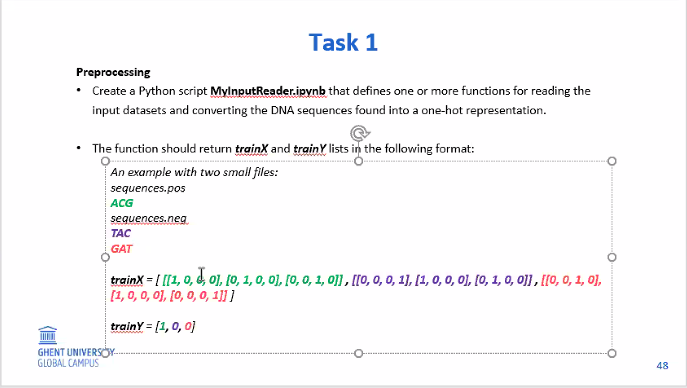

each nucleotide in each line of the dataset is converted to one-hot representation

In [4]:
def convertLines(lines):
    newLines = []
    for line in lines:
        newline = []
        for c in line.strip():
            if c == 'A':
                v = [1,0,0,0]
            elif c == 'C':
                v = [0,1,0,0]
            elif c == 'G':
                v = [0,0,1,0]
            elif c == 'T':
                v = [0,0,0,1]
            newline.append(v)
        newLines.append(newline)
    return newLines

def readInputs(f1,f2):
    lines_pos = open(f1).readlines()
    lines_neg = open(f2).readlines()

    X = []
    Y = []

    for l in convertLines(lines_pos):
        X.append(l)
        Y.append(1)
    for l in convertLines(lines_neg):
        X.append(l)
        Y.append(0)

    return X,Y

In [5]:
def regular_network():
  net_model = NetworkModel()
  net_model.addInputLayer()
  net_model.addFullyConnectedLayer(50)
  net_model.addFullyConnectedLayer(50)
  net_model.addOutputLayer()
  return net_model 

def conv_net():
  net_model = NetworkModel()
  net_model.addInputLayer()
  net_model.addConvLayer(10, 7)
  net_model.addMaxPoolLayer(5)
  net_model.addConvLayer(20, 5)
  net_model.addMaxPoolLayer(5)
  net_model.addFullyConnectedLayer(15)
  net_model.addOutputLayer()
  return net_model

In [1]:
from google.colab import drive
drive.mount("/content/mnts")
%cd "/content/mnts/My Drive/inputs"


Mounted at /content/mnts
/content/mnts/My Drive/inputs


In [9]:
nm = regular_network()
nm.printDetails()

trainX, trainY = readInputs('/content/mnts/My Drive/inputs/train.pos', '/content/mnts/My Drive/inputs/train.neg')
validX, validY = readInputs('/content/mnts/My Drive/inputs/valid.pos', '/content/mnts/My Drive/inputs/valid.neg')
testX, testY = readInputs('/content/mnts/My Drive/inputs/test.pos', '/content/mnts/My Drive/inputs/test.neg')

nm.train(trainX, trainY, validX, validY, 10)



/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:513: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  warnings.warn('`tf.layers.flatten` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '


####################################
Network information:
This network has 42702 trainable parameters.
 0. Input layer                                                                -> Output size: (?, 200, 4)
 1. Flatten layer                                                              -> Output size: (?, 800)
 2. Fully-connected layer   50 neurons, with ReLU                              -> Output size: (?, 50)
 3. Fully-connected layer   50 neurons, with ReLU                              -> Output size: (?, 50)
 4. Softmax (output) layer  2 neurons                                          -> Output size: (?, 2)

####################################
####################################

Number of training examples: 36000
Distribution of the training set:
  # elements of class 0 = 30000
  # elements of class 1 = 6000

Number of validation examples: 9000
Distribution of the validation set:
  # elements of class 0 = 7500
  # elements of class 1 = 1500

 epoch |   train cost   |   valid 

In [10]:
nm_2 = conv_net()
nm_2.printDetails()

trainX, trainY = readInputs('/content/mnts/My Drive/inputs/train.pos', '/content/mnts/My Drive/inputs/train.neg')
validX, validY = readInputs('/content/mnts/My Drive/inputs/valid.pos', '/content/mnts/My Drive/inputs/valid.neg')
testX, testY = readInputs('/content/mnts/My Drive/inputs/test.pos', '/content/mnts/My Drive/inputs/test.neg')

nm_2.train(trainX, trainY, validX, validY, 10)

#splice_sites
#candidates, pos = gatherSequencesFromFasta('/content/mnts/My Drive/inputs/full_sample.fasta')
#pred = nm.generatePredictions()
#formatPostitionsAndPredictions(candidates, pos, pred)

/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/convolutional.py:263: UserWarning: `tf.layers.conv1d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv1D` instead.
  warnings.warn('`tf.layers.conv1d` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/pooling.py:282: UserWarning: `tf.layers.max_pooling1d` is deprecated and will be removed in a future version. Please use `tf.keras.layers.MaxPooling1D` instead.
  warnings.warn('`tf.layers.max_pooling1d` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:513: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers

####################################
Network information:
This network has 3757 trainable parameters.
 0. Input layer                                                                -> Output size: (?, 200, 4)
 1. Convolutional layer     10 filters, width 7, zero padding, with ReLU       -> Output size: (?, 200, 10)
 2. Max pooling layer       pool size 5                                        -> Output size: (?, 40, 10)
 3. Convolutional layer     20 filters, width 5, zero padding, with ReLU       -> Output size: (?, 40, 20)
 4. Max pooling layer       pool size 5                                        -> Output size: (?, 8, 20)
 5. Flatten layer                                                              -> Output size: (?, 160)
 6. Fully-connected layer   15 neurons, with ReLU                              -> Output size: (?, 15)
 7. Softmax (output) layer  2 neurons                                          -> Output size: (?, 2)

####################################
################

In [21]:
def gatherSequencesFromFasta(filename):
  s = ''
  all_candidates = []
  all_positions = []
  for line in open(filename):
    if not line.startswith('>'):
      s += line.strip()

  for i in range(99, len(s)-99):
    if s[i:i+2] == 'GT':
      candidate_site = s[i-99:i+2+99]
      all_candidates.append(candidate_site)
      all_positions.append(i)

  return all_candidates, all_positions

def formatPositionsAndPredictions(cadidates, positions, predictions):
  print('------+--------------+-------')
  print('Pos   |  Candidate   | Pred  ')
  print('------+--------------+-------')
  for cand, pos, (_, pred) in zip(candidates, positions, predictions):
    print(' {:04d}  | {}  | {:1.4f} '.format(pos, cand[100-5:100+5], pred))


my metrics

In [18]:
def recall(predictions, labels):
  tp, tn, fp, fn = 0, 0, 0, 0
  for (_,p), l in zip(predictions, labels):
    if p >= 0.5 and l == 1:
      tp += 1
    elif p < 0.5 and l == 1:
      fn += 1
    elif p >= 0.5 and l == 0:
      fp += 1
    else:
      tn += 1
  return tp / (tp + fn)

def precision(predictions, labels):
  tp, tn, fp, fn = 0, 0, 0, 0
  for (_,p), l in zip(predictions, labels):
    if p >= 0.5 and l == 1:
      tp += 1
    elif p < 0.5 and l == 1:
      fn += 1
    elif p >= 0.5 and l == 0:
      fp += 1
    else:
      tn += 1
  return tp / (tp + fp)

def f1_score(predictions, labels):
  rec, prec = recall(predictions, labels), precision(predictions, labels)
  return 2 * rec * prec /(rec + prec)


In [19]:
nm = regular_network()
nm.printDetails()

trainX, trainY = readInputs('/content/mnts/My Drive/inputs/train.pos', '/content/mnts/My Drive/inputs/train.neg')
validX, validY = readInputs('/content/mnts/My Drive/inputs/valid.pos', '/content/mnts/My Drive/inputs/valid.neg')
testX, testY = readInputs('/content/mnts/My Drive/inputs/test.pos', '/content/mnts/My Drive/inputs/test.neg')

nm.train(trainX, trainY, validX, validY, 10)

pred = nm.generatePredictions(testX)

print(recall(pred, testY))
print(precision(pred, testY))
print(f1_score(pred, testY))

/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:513: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  warnings.warn('`tf.layers.flatten` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '


####################################
Network information:
This network has 42702 trainable parameters.
 0. Input layer                                                                -> Output size: (?, 200, 4)
 1. Flatten layer                                                              -> Output size: (?, 800)
 2. Fully-connected layer   50 neurons, with ReLU                              -> Output size: (?, 50)
 3. Fully-connected layer   50 neurons, with ReLU                              -> Output size: (?, 50)
 4. Softmax (output) layer  2 neurons                                          -> Output size: (?, 2)

####################################
####################################

Number of training examples: 36000
Distribution of the training set:
  # elements of class 0 = 30000
  # elements of class 1 = 6000

Number of validation examples: 9000
Distribution of the validation set:
  # elements of class 0 = 7500
  # elements of class 1 = 1500

 epoch |   train cost   |   valid 

In [24]:
nm = conv_net()
nm.printDetails()

trainX, trainY = readInputs('/content/mnts/My Drive/inputs/train.pos', '/content/mnts/My Drive/inputs/train.neg')
validX, validY = readInputs('/content/mnts/My Drive/inputs/valid.pos', '/content/mnts/My Drive/inputs/valid.neg')
testX, testY = readInputs('/content/mnts/My Drive/inputs/test.pos', '/content/mnts/My Drive/inputs/test.neg')

nm.train(trainX, trainY, validX, validY, 10)

#pred = nm.generatePredictions(testX)

print(recall(pred, testY))
print(precision(pred, testY))
print(f1_score(pred, testY))

#splice_sites
candidates, pos = gatherSequencesFromFasta('/content/mnts/My Drive/inputs/full_sample.fasta')
pred = nm.generatePredictions(testX)
formatPositionsAndPredictions(candidates, pos, pred)

/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/convolutional.py:263: UserWarning: `tf.layers.conv1d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv1D` instead.
  warnings.warn('`tf.layers.conv1d` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/pooling.py:282: UserWarning: `tf.layers.max_pooling1d` is deprecated and will be removed in a future version. Please use `tf.keras.layers.MaxPooling1D` instead.
  warnings.warn('`tf.layers.max_pooling1d` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:513: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers

####################################
Network information:
This network has 3757 trainable parameters.
 0. Input layer                                                                -> Output size: (?, 200, 4)
 1. Convolutional layer     10 filters, width 7, zero padding, with ReLU       -> Output size: (?, 200, 10)
 2. Max pooling layer       pool size 5                                        -> Output size: (?, 40, 10)
 3. Convolutional layer     20 filters, width 5, zero padding, with ReLU       -> Output size: (?, 40, 20)
 4. Max pooling layer       pool size 5                                        -> Output size: (?, 8, 20)
 5. Flatten layer                                                              -> Output size: (?, 160)
 6. Fully-connected layer   15 neurons, with ReLU                              -> Output size: (?, 15)
 7. Softmax (output) layer  2 neurons                                          -> Output size: (?, 2)

####################################
################